In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pydicom as pdc
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import SimpleITK as sitk
import glob
import os
import shutil
from skimage import exposure

## load patient number and disease

In [4]:
import pandas as pd
path = '../Code/benchmark_liver_tumor/raw/'
patient_meta = pd.read_csv(path + 'patient_meta.csv')
patient_meta = patient_meta[['RANDOM_PT_NO','SEX','AGE','PHASE',"DX"]]
patient_meta=patient_meta[['RANDOM_PT_NO','DX']]

## load label images

In [153]:
path = "./benchmark_liver_tumor/raw/"
folder_list = os.listdir(path)
img_folders=[]
for folder in folder_list:
    if not folder.endswith(".xlsx"):
        if "SN"in folder:
            img_folders.append(folder)

In [154]:
from PIL import Image
label_df = pd.DataFrame()
for folder in img_folders:
    label_list = os.listdir(path+folder+'/label/')
    idx = 0
    for image_name in label_list:
        im = Image.open(path+folder+'/label/'+image_name)
        image_name=image_name.split('.')[0].split('_')[-1]
        im = np.array(im)
        label_df=label_df.append(pd.Series([folder,image_name,im.mean()]),ignore_index=True)
    #     plt.figure()
    #     plt.title(im.mean())
    #     plt.imshow(im,cmap='gray')


KeyboardInterrupt: 

In [1]:
label_df.columns = ['patient_no','img_idx','mean_annotation']
label_df.tail()

NameError: name 'label_df' is not defined

In [7]:
[dx for dx in np.unique(patient_meta['DX']) if 'metastasis' not in dx]

['HCC', 'NET', 'cholangiocarcinoma', 'lymphoma']

In [8]:
import collections
collections.Counter(patient_meta['DX'])

Counter({'HCC': 30,
         'cholangiocarcinoma': 14,
         'metastasis from pancreas': 14,
         'metastasis from stomach': 2,
         'metastasis from CBD': 1,
         'metastasis from breast': 9,
         'metastasis from colon': 5,
         'metastasis from lung': 14,
         'metastasis from uterus': 1,
         'metastasis from esophagus': 3,
         'metastasis from prostate': 1,
         'metastasis from choroidal melanoma': 2,
         'metastasis from unkown origin': 1,
         'NET': 2,
         'metastasis from cervix': 2,
         'lymphoma': 1,
         'metastasis from GB': 1})

## class 나누는 기준 (충분한 데이터가 있으면 클래스로, 아니면 기타로)
- metastasis: 0
- HCC: 1 
- cholangiocarcinoma: 2
- 기타(데이터 충분하지 않음): 3
- 정상(annotation img 값이 모두 0): -1

In [9]:
def find_disease(patient_num):
    dx=np.array(patient_meta[patient_meta['RANDOM_PT_NO'] == patient_num]['DX'])[0]
    if 'metastasis'in dx:
        return 0
    elif dx == 'HCC':
        return 1
    elif dx == 'cholangiocarcinoma':
        return 2
    else:
        return 3
    
label_df['DX']=label_df.apply(lambda x: find_disease(x[0]) if float(x[2])>0.0 else -1, axis=1)

In [12]:
label_df.to_csv('metadata/label_df.csv',index = False)

# CNN

In [ ]:
#  !pip install --upgrade tensorflow_hub

In [13]:
import pydicom as pdc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
import tensorflow_hub as hub
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [155]:
label_df = pd.read_csv('metadata/label_df.csv')
label_df.head()


,patient_no,img_idx,mean_annotation,DX
0,SN00017916,1,0.0,-1
1,SN00017916,2,0.0,-1
2,SN00017916,3,0.0,-1
3,SN00017916,4,0.0,-1
4,SN00017916,5,0.0,-1


In [156]:
total_patient=len(np.unique(label_df['patient_no']))
train_no=round(total_patient*0.7)
total_patient - train_no, train_no

(31, 72)

In [157]:
train_patients=np.unique(label_df['patient_no'])[:train_no]
test_patients=np.unique(label_df['patient_no'])[train_no:]

In [158]:
Y=pd.get_dummies(label_df['DX'])

In [164]:
def dcm2array(dcm_path, size=(128,128)):
    img = cv2.normalize(cv2.resize(pdc.dcmread(dcm_path).pixel_array, dsize=size), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img

def dcm2clahe2array(dcm_path, size=(128,128)):
    img = cv2.resize(pdc.dcmread(dcm_path).pixel_array, dsize=size)
    img = exposure.equalize_adapthist(img, clip_limit=0.03, nbins = 512)
    img = cv2.normalize(img, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img

   
X_train_pre = []
X_test_pre = []
def find_dcmfile(patient_no,img_idx):
    path = f'./benchmark_liver_tumor/raw/{patient_no}'
    folder_list = [img for img in os.listdir(path) if img.endswith('.dcm')]
    img_path = f'./benchmark_liver_tumor/raw/{patient_no}/{folder_list[img_idx-1]}'
    if patient_no in train_patients:
        X_train_pre.append(dcm2clahe2array(img_path))
    else:
        X_test_pre.append(dcm2clahe2array(img_path))
x=label_df.apply(lambda x: find_dcmfile(x[0],x[1]),axis=1)

In [165]:
Y=pd.get_dummies(label_df['DX'])
Y_train = Y[:len(X_train_pre)]
Y_test = Y[len(X_train_pre):]

In [166]:
X_train = np.expand_dims(np.array(X_train_pre),3)
X_test = np.expand_dims(np.array(X_test_pre),3)
X_train.shape,X_test.shape, Y_train.shape, Y_test.shape

((9977, 128, 128, 1), (4354, 128, 128, 1), (9977, 5), (4354, 5))

In [2]:
# save x (load image)
#np.save('models/np/X_train2', X_train)
#np.save('models/np/X_test2', X_test)
#np.save('models/np/Y_train2', Y_train)
#np.save('models/np/Y_test2', Y_test)

#load
X_train = np.load('models/np/X_train2.npy')
X_test = np.load('models/np/X_test2.npy')
Y_train = np.load('models/np/Y_train2.npy')
Y_test = np.load('models/np/Y_test2.npy')

NameError: name 'np' is not defined

In [5]:
# Build Model (3D-CNN)
cnn_input = tf.keras.Input((X.shape[1], X.shape[2],1))
h = tf.keras.layers.Reshape((X.shape[1], X.shape[2],1))(cnn_input)
h = tf.keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool2D((2))(h)
h = tf.keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool2D((2))(h)
h = tf.keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool2D((2))(h)
h = tf.keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool2D((2))(h)
h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='relu')(h)
h = tf.keras.layers.Dense(64, activation='relu')(h)
cnn_output = tf.keras.layers.Dense(Y.shape[1], activation='softmax')(h)
cnn = tf.keras.Model(cnn_input, cnn_output)
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.summary()

# display(Image(filename="./model/cnn.png"))

NameError: name 'X' is not defined

In [19]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [169]:
# Train Model

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_history = cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=30, shuffle=True, verbose=2, callbacks=[es])


Train on 9977 samples, validate on 4354 samples
Epoch 1/100
9977/9977 - 22s - loss: 0.5165 - accuracy: 0.8566 - val_loss: 0.4858 - val_accuracy: 0.8282
Epoch 2/100
9977/9977 - 22s - loss: 0.3095 - accuracy: 0.8813 - val_loss: 0.5535 - val_accuracy: 0.8234
Epoch 3/100
9977/9977 - 22s - loss: 0.2147 - accuracy: 0.9180 - val_loss: 0.7058 - val_accuracy: 0.8025
Epoch 4/100
9977/9977 - 23s - loss: 0.1510 - accuracy: 0.9416 - val_loss: 0.8892 - val_accuracy: 0.8179
Epoch 5/100
9977/9977 - 22s - loss: 0.1073 - accuracy: 0.9563 - val_loss: 1.0849 - val_accuracy: 0.8027
Epoch 6/100
9977/9977 - 22s - loss: 0.0911 - accuracy: 0.9627 - val_loss: 1.1201 - val_accuracy: 0.8121
Epoch 7/100
9977/9977 - 21s - loss: 0.0765 - accuracy: 0.9697 - val_loss: 1.3837 - val_accuracy: 0.8167
Epoch 8/100
9977/9977 - 22s - loss: 0.0571 - accuracy: 0.9774 - val_loss: 1.5971 - val_accuracy: 0.8039
Epoch 9/100
9977/9977 - 21s - loss: 0.0536 - accuracy: 0.9814 - val_loss: 1.6778 - val_accuracy: 0.8135
Epoch 10/100
997

In [21]:
cnn.evaluate(X_test,y_test)

135/135 [==============================] - 2s 17ms/step - loss: 0.1959 - accuracy: 0.9660


[0.1958737075328827, 0.9660465121269226]

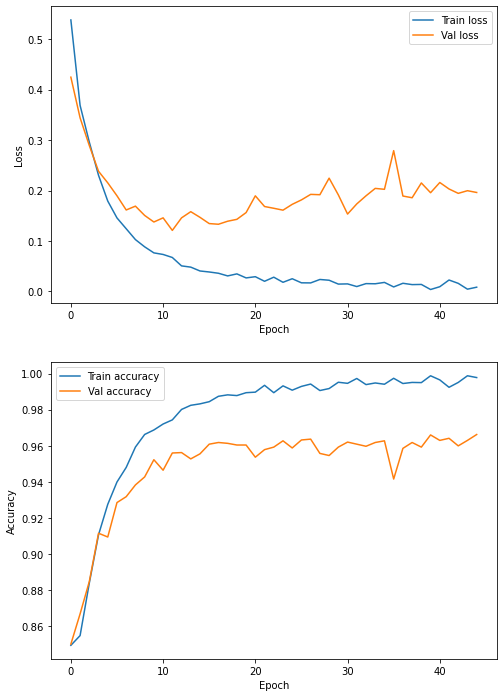

In [22]:
# visualize history
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
            label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
            label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val accuracy')
    plt.legend()
plot_history(cnn_history)

In [23]:
# save model
cnn.save("./models/basic_cnn_clahe.h5")

# model load하는 경우
# reconstructed_model  = tf.keras.models.load_model("./models/basic_cnn.h5")

In [115]:
cnn =  tf.keras.models.load_model("./models/basic_cnn.h5")
cnn.predict(X_test)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


array([[1.0000000e+00, 2.3330944e-21, 9.6656592e-19, 1.5132811e-22,
        5.5567697e-27],
       [1.0000000e+00, 1.3680320e-12, 5.1766213e-17, 2.5525402e-28,
        2.9379915e-19],
       [1.0000000e+00, 1.3132820e-23, 1.0308952e-12, 1.6737862e-09,
        1.8672731e-19],
       ...,
       [1.0000000e+00, 0.0000000e+00, 1.3467419e-36, 0.0000000e+00,
        0.0000000e+00],
       [1.0000000e+00, 7.5504845e-12, 6.0955465e-18, 2.0682007e-26,
        4.2295784e-19],
       [1.0000000e+00, 5.5633079e-25, 2.1071223e-30, 0.0000000e+00,
        1.8104718e-27]], dtype=float32)

In [31]:
cnn.history

## CAM(Class Activation Map)으로 나타내기

In [209]:
def dcm2array(dcm_path, size=(128,128)):
    img = cv2.normalize(cv2.resize(pdc.dcmread(dcm_path).pixel_array, dsize=size), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img

In [213]:
import numpy as np
import tensorflow as tf

layers_name = ['activation_1']
IMAGE_PATH = './benchmark_liver_tumor/raw/SN00017916/SN00017916_0021.dcm'

# Model to examine
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True)
# model = tf.keras.models.load_model("./models/basic_cnn.h5")

# Image to pass as input

# img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(128, 128))
# img = tf.keras.preprocessing.image.img_to_array(img)

img = dcm2array(IMAGE_PATH)

# Get the outputs of layers we want to inspect
outputs = [
    layer.output for layer in model.layers
    if layer.name in layers_name
]

# Create a connection between the input and those target outputs
activations_model = tf.keras.models.Model(model.inputs, outputs=outputs)
activations_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Get their outputs
activations_1 = activations_model.predict(np.array([img]))

In [214]:
import numpy as np
import tensorflow as tf

# Layer name to inspect
layer_name = 'block3_conv1'

epochs = 100
step_size = 1.
filter_index = 0

# Create a connection between the input and the target layer
model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
submodel = tf.keras.models.Model([model.inputs[0]], [model.get_layer(layer_name).output])

# Initiate random noise
input_img_data = np.random.random((1, 128, 128, 1))
input_img_data = (input_img_data - 0.5) * 20 + 128.

# Cast random noise from np.float64 to tf.float32 Variable
input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

# Iterate gradient ascents
for _ in range(epochs):
    with tf.GradientTape() as tape:
        outputs = submodel(input_img_data)
        loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
    grads = tape.gradient(loss_value, input_img_data)
    normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
    input_img_data.assign_add(normalized_grads * step_size)

553467904/553467096 [==============================] - 99s 0us/step


In [25]:
SN00017916_0021.dcm

SN00017916_0021.dcm

NameError: name 'SN00017916_0021' is not defined

### Testing CAM

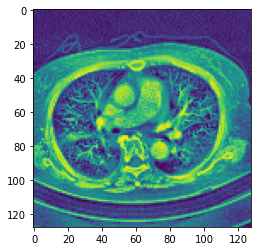

In [116]:
from PIL import Image
from matplotlib.pyplot import imread
import matplotlib.image as mpimg
from skimage import color
from skimage import io

img_path = '../Code/benchmark_liver_tumor/train/train/SN00017916/SN00017916_1.png'
img = color.rgb2gray(io.imread(img_path))
img = cv2.resize(img, dsize=(128,128))
pic = plt.imshow(img)   
x = image.img_to_array(img)

In [117]:
x.shape

(128, 128, 1)

In [118]:
np.expand_dims(x,axis=0).shape

(1, 128, 128, 1)

In [119]:
preds = cnn.predict(np.expand_dims(x,axis=0))

In [120]:
preds

array([[1., 0., 0., 0., 0.]], dtype=float32)

In [121]:
#import pandas as pd
#from keras.applications.vgg16 import decode_predictions
#predictions = pd.DataFrame(preds, columns=['col1','category','probability']).iloc[:,1:]
#print('PREDICTION:',predictions.loc[0,'category'])

In [122]:
## Call final convolutaional layer
cnn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 16)      80        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 16)        1040      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 16)       

In [145]:
#cnn.layers
last_conv_layer = cnn.get_layer('conv2d_9')

# Get the Gradient 
from keras import backend as K
argmax = np.argmax(preds[0])
output = cnn.output[:, argmax]
grads = K.gradients(output, last_conv_layer.output)[0]

In [146]:
last_conv_layer.output[0]

<tf.Tensor 'strided_slice_15:0' shape=(128, 128, 16) dtype=float32>

In [147]:
pooled_grads

<tf.Tensor 'Mean_8:0' shape=(16,) dtype=float32>

In [148]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([cnn.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

InvalidArgumentError: Input to reshape is a tensor with 16384 values, but the requested shape has 2097152
	 [[{{node reshape_11/Reshape}}]]

In [149]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

NameError: name 'conv_layer_output_value' is not defined

### 무시할 코드부분

In [150]:
heatmap_model = tf.keras.models.Model(
    [cnn.inputs], [cnn.get_layer('conv2d_12').output, cnn.output]
)

In [151]:
with tf.GradientTape() as tape:
    conv_output, predictions = heatmap_model(np.expand_dims(x,axis=0))
    loss = predictions[:, np.argmax(predictions[0])]

grads = tape.gradient(loss, conv_output)

NotImplementedError: Cannot convert a symbolic Tensor (strided_slice_17:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [97]:
tf.compat.v1.disable_eager_execution()

In [99]:
castConvOutputs = tf.cast(conv_output > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# My goal was to create the class activation map for single image, so we are skipping axis=0 which is meant to have the batch_size of images at axis=0
convOutputs = conv_output[0]
guidedGrads = guidedGrads[0]

RuntimeError: Attempting to capture an EagerTensor without building a function.